# Stability of BMTs on the Circle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mergeTrees import *

### Creating a density on the circle

The following creates a particular density on the circle with two modes, arranged symmetrically. This will serve as a running synthetic example for the rest of the notebook.

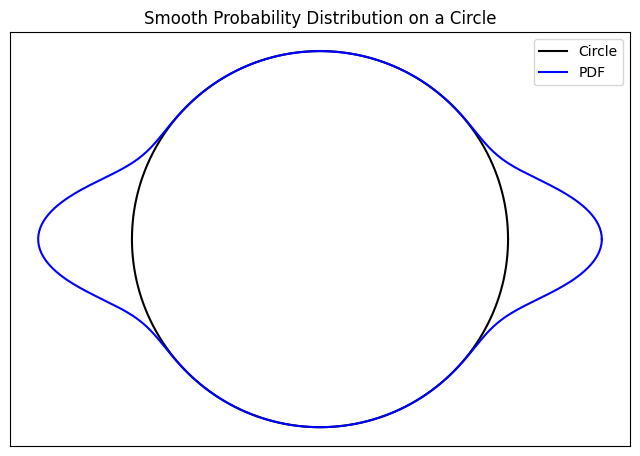

In [14]:
def smooth_circular_distribution(theta):
    """
    Define a smooth probability density function over the circle.
    Args:
        theta: Angle in radians (array-like).

    Returns:
        PDF values corresponding to each theta.
    """
    # Example: A Gaussian-like bump on the circle centered at theta=pi
    return np.exp(-0.5 * ((theta - np.pi) % (2 * np.pi) - np.pi)**2 / 0.2**2) + np.exp(-0.5 * ((theta) % (2 * np.pi) - np.pi)**2 / 0.2**2)

# Generate angles for the circle
angles = np.linspace(0, 2 * np.pi, 1000)
sparse_angles = np.linspace(0,2*np.pi,50)

# Evaluate the PDF
pdf_values = smooth_circular_distribution(angles)

# Normalize the PDF
pdf_values /= np.trapz(pdf_values, angles)  # Ensure integral over the circle is 1

# Convert PDF values to Cartesian coordinates
x_circle = np.cos(angles)
y_circle = np.sin(angles)

x_pdf = (1 + pdf_values/2) * np.cos(angles)
y_pdf = (1 + pdf_values/2) * np.sin(angles)

# Plot the circle and the PDF
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black")  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
plt.title("Smooth Probability Distribution on a Circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()


### Deviation Function

We calculate the associated deviation function (with $p=2$) for the distribution above. The plot shows the distribution and the deviation function after "unwrapping" the circle.

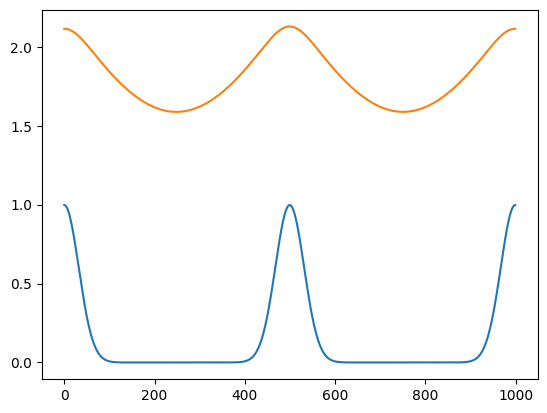

In [15]:
deviation_values = np.array([np.sum([min(np.abs(angles[j]-angles[i]),
                                         2*np.pi-(np.abs(angles[j]-angles[i])))**2*pdf_values[j]*(2*np.pi/1000) 
                                     for j in range(len(angles))])**(1/2) 
                             for i in range(len(angles))])

plt.plot(pdf_values)
plt.plot(deviation_values)
plt.show()

### Fréchet Means

Next we plot the distribution on the circle, the deviation function on the circle, and the Fréchet mean set. In this case, there are two points in the set of Fréchet means (i.e., global minimizers of the deviation fuction.

We rescale the deviation function to get a nicer picture. This is the `scale_factor` parameter, below.

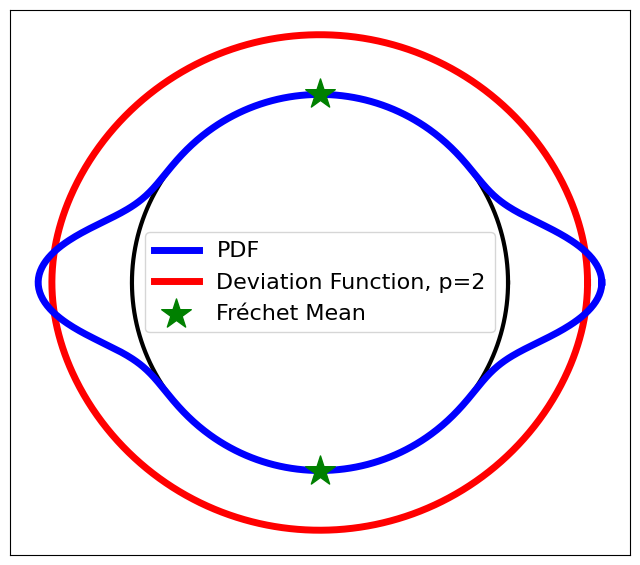

In [17]:
# Scale the deviation function to get a nicer picture
scale_factor = 1/5

# Plot the circle and the PDF
x_min = np.array([0,0])
y_min = np.array([1,-1])

x_deviation = (1 + scale_factor*deviation_values) * np.cos(angles)
y_deviation = (1 + scale_factor*deviation_values) * np.sin(angles)

plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, color="black", linewidth=3)  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue", linewidth=5, zorder = 5) 
plt.plot(x_deviation, y_deviation, label="Deviation Function, p=2", color="red", linewidth=5)  # PDF superimposed
plt.scatter(x_min, y_min, color="green", s=500, marker="*", label="Fréchet Mean", alpha=1,zorder=10)
plt.gca().set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=16)

plt.savefig('distribution.png', format='png', dpi=300)

plt.show()

### Sampling points from the distribution

We want to study the behavior of the Fréchet mean when we empirically approximate the distribution.

This function samples angles from the given pdf on the circle.

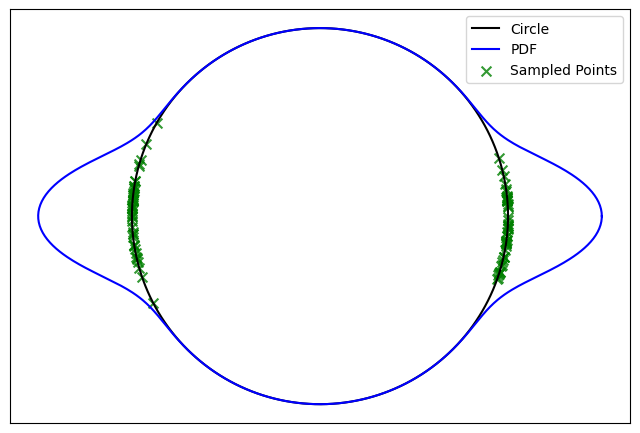

In [18]:
# Sample points from the distribution on the circle
def sample_points_from_distribution(n, angles, pdf_values, random_seed = None):
    """
    Sample n points from the given probability distribution on the circle.

    Args:
        n: Number of points to sample.
        angles: Array of angles (in radians).
        pdf_values: Array of PDF values corresponding to the angles.

    Returns:
        Sampled points as (x, y) coordinates.
    """
    # Normalize PDF for use as probabilities
    probabilities = pdf_values / np.sum(pdf_values)

    # Sample angles based on the distribution
    if random_seed is None:
        sampled_angles = np.random.choice(angles, size=n, p=probabilities)
    else:
        rng = np.random.RandomState(random_seed)
        sampled_angles = rng.choice(angles, size=n, p=probabilities)

    # Convert sampled angles to circle coordinates
    x_samples = np.cos(sampled_angles)
    y_samples = np.sin(sampled_angles)

    return sampled_angles, x_samples, y_samples

# Example #
n_samples = 100
sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)

# Plot the sampled points #
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black")  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
plt.scatter(x_samples, y_samples, color="green", s=50, marker="x", label="Sampled Points", alpha=0.8)  # Adjusted marker and size
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()

### Computing Fréchet Means from Samples

We'll use the following functions later on. The most important is the Fréchet mean function.

In [19]:
# Distance between two points on the circle:
def circular_distance(angle1,angle2):

    # angle1 and angle2 should be between 0 and 2pi

    first_distance = np.abs(angle1-angle2)
    second_distance = 2*np.pi-first_distance

    return min([first_distance,second_distance])

# Fréchet function for sampled points on the circle
def circular_frechet_function(angle,sampled_angles,p=2):

    distances = [circular_distance(angle,sampled_angle) for sampled_angle in sampled_angles]
    frechet_value = np.sum([distance**p for distance in distances])

    return frechet_value

# Helper function which shifts the sampled angles by a given angle
def shift_angles(angle,sampled_angles):

    shifted = []
    for sampled_angle in sampled_angles:
        if sampled_angle > angle:
            shifted.append(sampled_angle - angle)
        else:
            shifted.append(sampled_angle - angle + 2*np.pi)

    return shifted

# Computing the Fréchet mean for a finite sample of points on the circle
def circular_frechet_mean(angles,sampled_angles):

    frechet_mean = 0
    
    for angle in angles:
        shifted = shift_angles(angle,sampled_angles)
        mean = (np.mean(shifted) + angle)%(2*np.pi)
        if circular_frechet_function(mean,sampled_angles) < circular_frechet_function(frechet_mean,sampled_angles):
            frechet_mean = mean
    
    return frechet_mean

This code finds the global minimum of the Fréchet function for a sample coming from the pdf.

This simple code assumes that there is a unique global minimum. This is a generic property of the randomly sampled set.

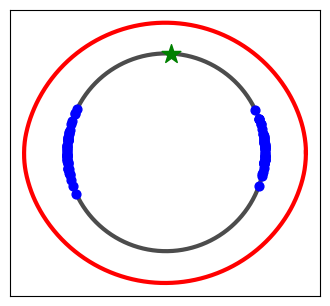

In [20]:
n_samples = 100
scale_factor = 1/5

sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)
frechet_mean = circular_frechet_mean(sparse_angles,sampled_angles)

deviation_values_sampled = np.array([np.sum([min(np.abs(sampled_angles[j]-angles[i]),2*np.pi-(np.abs(sampled_angles[j]-angles[i])))**2*1/n_samples for j in range(len(sampled_angles))])**(1/2) for i in range(len(angles))])
x_deviation_sampled = (1 + scale_factor*deviation_values_sampled) * np.cos(angles)
y_deviation_sampled = (1 + scale_factor*deviation_values_sampled) * np.sin(angles)

# Plot the sampled points
plt.figure(figsize=(4, 4))
plt.plot(x_circle, y_circle, color="black", linewidth = 3,alpha = 0.7)  # Circle outline
# plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
plt.plot(x_deviation_sampled, y_deviation_sampled, label="Empirical Fréchet Variance", color="red", linewidth = 3, zorder=0)  # PDF superimposed
plt.scatter(x_samples, y_samples, color="blue", s=40, marker="o", label="Sampled Points", alpha=1, zorder=5)  # Adjusted marker and size
plt.scatter(np.cos(frechet_mean), np.sin(frechet_mean), color="green", s=200, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)

# plt.title("Sampled Points from the Circular Distribution")
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect("equal", adjustable="box")
# plt.legend(fontsize = 14)

plt.savefig('empirical1.png', format='png', dpi=300)

plt.show()

The following code runs the above several times and produces a figure. We'll set a random seed for reproducibility.

(This particular random seed was selected because it gives a nice picture of the different behaviors.)

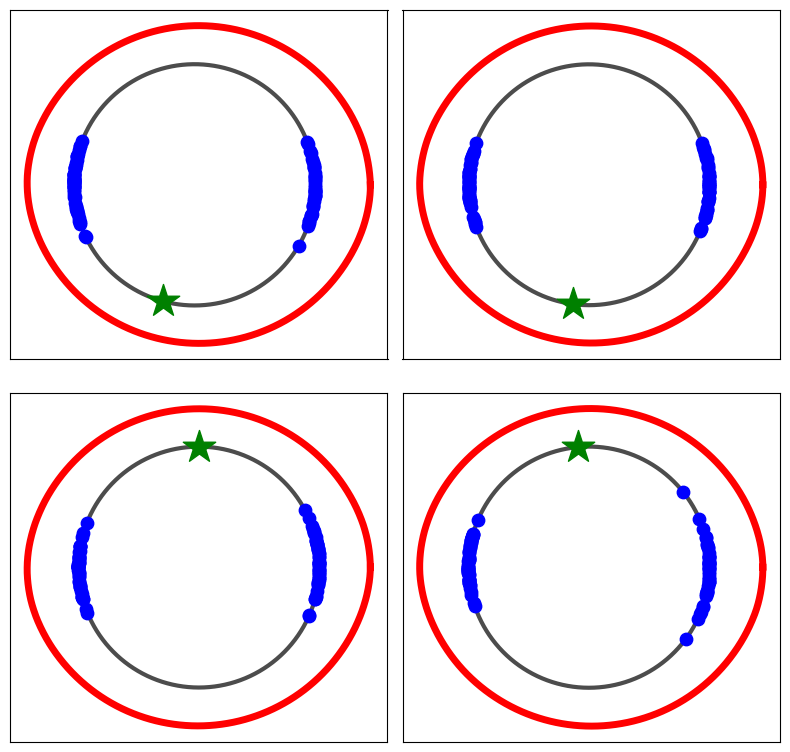

In [21]:
# Number of samples
n_samples = 100
random_seed = 7
scale_factor = 1/5

# Create a 2-row by 3-column grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()  # Flatten to index easily

deviation_values_list = []

for i in range(4):
    # Generate samples
    sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values, random_seed = random_seed+i)
    frechet_mean = circular_frechet_mean(sparse_angles, sampled_angles)

    # Compute deviation values
    deviation_values_sampled = np.array([
        np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
                for j in range(len(sampled_angles))]) ** (1/2) 
        for i in range(len(angles))
    ])
    x_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.cos(angles)
    y_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.sin(angles)

    deviation_values_list.append(deviation_values_sampled)

    # Plot in the corresponding subplot
    ax = axes[i]
    ax.plot(x_circle, y_circle, color="black", linewidth=3, alpha=0.7)  # Circle outline
    ax.plot(x_deviation_sampled, y_deviation_sampled, label="Empirical Fréchet Variance", color="red", linewidth=5, zorder=0)
    ax.scatter(x_samples, y_samples, color="blue", s=80, marker="o", label="Sampled Points", alpha=1, zorder=5)
    ax.scatter(np.cos(frechet_mean), np.sin(frechet_mean), color="green", s=600, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", adjustable="box")

# Adjust layout
plt.tight_layout()

# Save the full figure
plt.savefig('empirical_grid.png', format='png', dpi=300)

# Show the figure
plt.show()

### Stability of Merge Trees

Now we'll generate random samples (using the same random seed above) and corresponding merge trees. This is based on the merge tree algorithm from the auxiliary Python file.

The first picture generates the barycenteric merge tree for the true PDF.

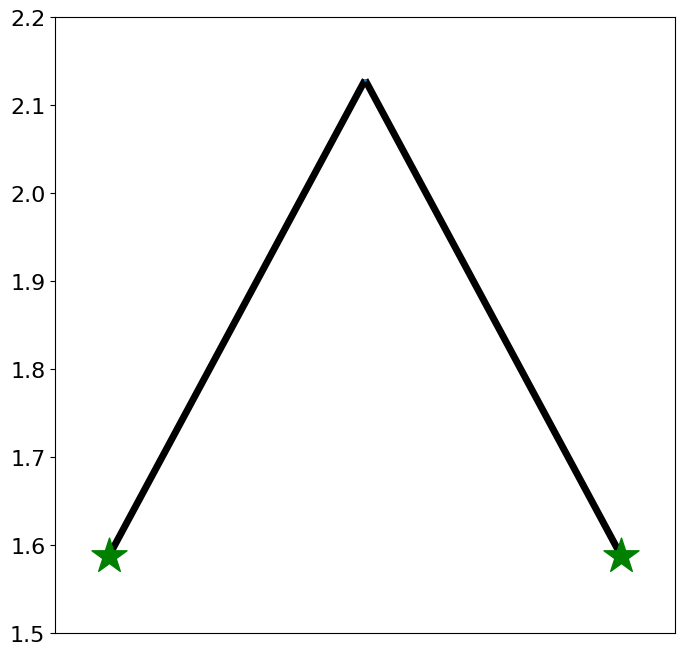

In [22]:
G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])
G.add_edge(len(angles)-1,0)

f = {i:deviation_values[i] for i in range(len(angles))}

T = get_merge_tree(G,f)

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5)

x_min = np.array([pos[0][0],pos[1][0]])
y_min = np.array([pos[0][1],pos[1][1]])

plt.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
ax.set_ylim(1.5, 2.2)

plt.savefig('distribution_merge_tree.png', format='png', dpi=300)

Now we generate merge trees from samples. We use the same random seed as above, for reproducibility.

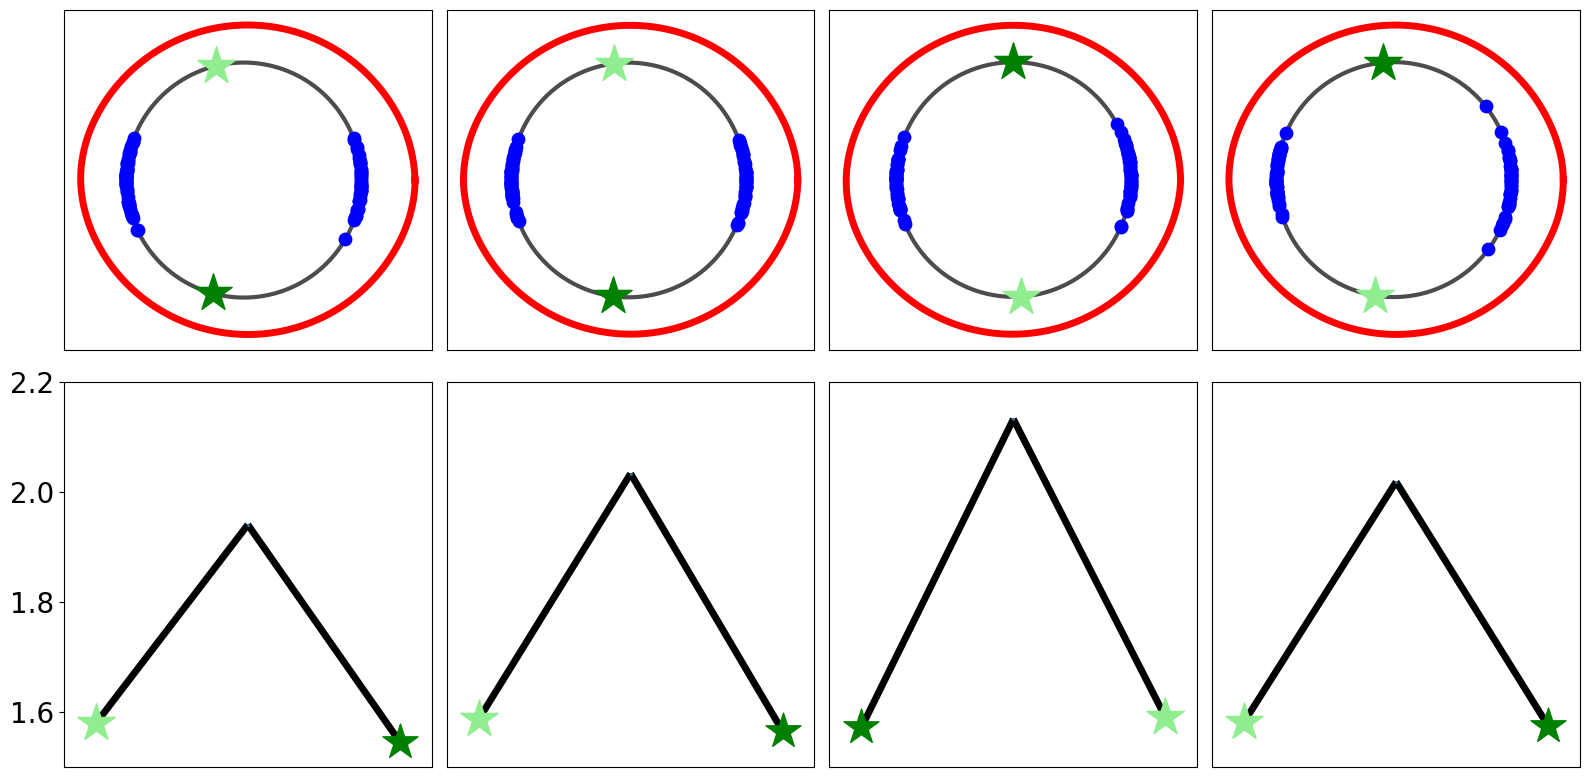

In [13]:
G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])
scale_factor = 1/5

simplify = True

# Create a 2-row by 3-column grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8.1))
axes = axes.flatten()  # Flatten to index easily

deviation_values_list = []

n_samples = 100

for i in range(4):
    # Generate samples
    sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values, random_seed = random_seed + i)
    frechet_mean = circular_frechet_mean(sparse_angles, sampled_angles)

    # Compute deviation values
    deviation_values_sampled = np.array([
        np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
                for j in range(len(sampled_angles))]) ** (1/2) 
        for i in range(len(angles))
    ])
    x_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.cos(angles)
    y_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.sin(angles)

    deviation_values_list.append(deviation_values_sampled)

    # Plot in the corresponding subplot
    ax = axes[i]
    ax.plot(x_circle, y_circle, color="black", linewidth=3, alpha=0.7)  # Circle outline
    ax.plot(x_deviation_sampled, y_deviation_sampled, label="Empirical Fréchet Variance", color="red", linewidth=5, zorder=0)
    ax.scatter(x_samples, y_samples, color="blue", s=80, marker="o", label="Sampled Points", alpha=1, zorder=5)
    ax.scatter(np.cos(frechet_mean), np.sin(frechet_mean), color="green", s=800, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", adjustable="box")

    f = {i:deviation_values_sampled[i] for i in range(len(angles))}
    
    T = get_merge_tree(G,f)
    
    if simplify:
        T = simplify_merge_tree(T)
    
    height = {node:T.nodes[node]['height'] for node in T.nodes()}
    pos = mergeTree_pos(T,height)
    
    ax = axes[i+4]

    ax.set_ylim(1.5, 2.2)
    
    nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5,ax = ax)

    leaves = [node for node in T.nodes() if T.degree(node)==1]

    if T.nodes[leaves[0]]['height'] < T.nodes[leaves[1]]['height']:
        min_node = leaves[0]
        other_node = leaves[1]
    else:
        min_node = leaves[1]
        other_node = leaves[0]

    x_min = pos[min_node][0]
    y_min = pos[min_node][1]

    x_other = pos[other_node][0]
    y_other = pos[other_node][1]
    
    ax.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)
    ax.scatter(x_other, y_other, color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    if i == 0:
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize=20)
    else:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


    other_node_circle_value = get_key(f,T.nodes[other_node]['height'])[0]

    ax = axes[i]

    ax.scatter(x_circle[other_node_circle_value], y_circle[other_node_circle_value], color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    

# Adjust layout
plt.tight_layout()

# Save the full figure
plt.savefig('empirical_grid_trees.png', format='png', dpi=300)

# Show the figure
plt.show()

### Median

We now do similar illustrations of Fréchet medieans. 

The first function computes the median of a pair of Diracs, using the explicit formula in the paper.

In [23]:
def median_function(x):
    
    median_values = []
    
    for j in range(500):
        median_values.append(angles[j]*(2*x-1)+np.pi*(1-x))
        
    median_values += median_values[::-1]
    
    return np.array(median_values)

The following code produces a figure to illustrate the median on the circle.

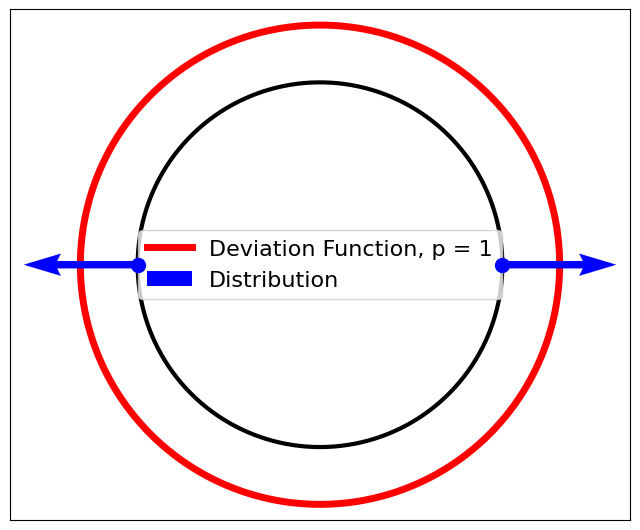

In [24]:
x = 0.5  # Change this value as needed

# Generate unit circle points
theta = np.linspace(0, 2*np.pi, 1000)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Define arrows
arrow1_base = (1, 0)
arrow1_dx = x
arrow1_dy = 0

arrow2_base = (-1, 0)
arrow2_dx = -(1 - x)
arrow2_dy = 0

median_values = median_function(x)

x_median = (1 + scale_factor*median_values) * np.cos(angles)
y_median = (1 + scale_factor*median_values) * np.sin(angles)

# Create plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(circle_x, circle_y, 'k',linewidth = 3)  # Plot unit circle
ax.plot(x_median, y_median,linewidth = 5, color = 'red', label = 'Deviation Function, p = 1')  # Plot unit circle
ax.quiver(*arrow1_base, arrow1_dx, arrow1_dy, angles='xy', scale_units='xy', scale=0.8, width = .012, color='b', label="Distribution", zorder = 5)
ax.quiver(*arrow2_base, arrow2_dx, arrow2_dy, angles='xy', scale_units='xy', scale=0.8, width = .012, color='b', zorder = 5)
ax.scatter([1,-1], [0,0], color="b", s=100, marker="o", alpha=1, zorder=10)
if x > 0.5:
    ax.scatter([1], [0], color="green", s=600, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)
elif x < 0.5:
    ax.scatter([-1], [0], color="green", s=600, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)

# Formatting
ax.set_xlim(-1.7, 1.7)
ax.set_ylim(-1.4, 1.4)
ax.set_aspect('equal')
#     ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
#     ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=16,loc='center')
#     ax.set_title("Unit Circle with Two Arrows")
plt.savefig('diracs.png', format='png', dpi=300)

# Show plot
plt.show()


Next we show medians are unstable.

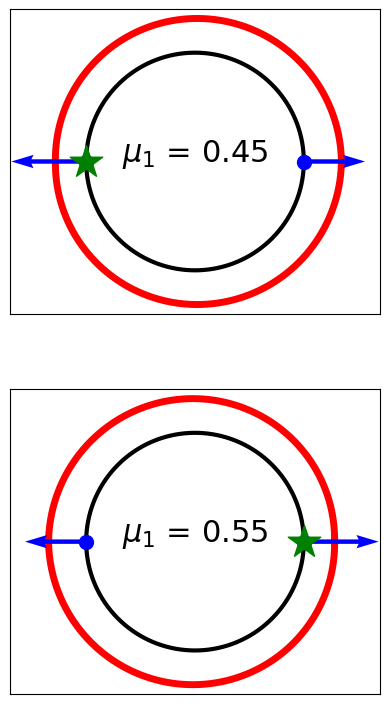

In [25]:
# Generate unit circle points
theta = np.linspace(0, 2 * np.pi, 1000)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Function to generate plot for a given x value
def plot_figure(ax, x):
    arrow1_base = (1, 0)
    arrow1_dx = x
    arrow1_dy = 0

    arrow2_base = (-1, 0)
    arrow2_dx = -(1 - x)
    arrow2_dy = 0

    median_values = median_function(x)
    angles = np.linspace(0, 2 * np.pi, len(median_values))
    x_median = (1 + 1 / 5 * median_values) * np.cos(angles)
    y_median = (1 + 1 / 5 * median_values) * np.sin(angles)
    
    ax.plot(circle_x, circle_y, 'k', linewidth=3)  # Plot unit circle
    ax.plot(x_median, y_median, linewidth=5, color='red', label='Fréchet Variance, p = 1')
    ax.quiver(*arrow1_base, arrow1_dx, arrow1_dy, angles='xy', scale_units='xy', scale=0.8, width=0.012, color='b', label="Distribution", zorder=5)
    ax.quiver(*arrow2_base, arrow2_dx, arrow2_dy, angles='xy', scale_units='xy', scale=0.8, width=0.012, color='b', zorder=5)
    ax.scatter([1, -1], [0, 0], color="b", s=100, marker="o", alpha=1, zorder=10)
    
    if x > 0.5:
        ax.scatter([1], [0], color="green", s=600, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)
    elif x < 0.5:
        ax.scatter([-1], [0], color="green", s=600, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)

    ax.set_xlim(-1.7, 1.7)
    ax.set_ylim(-1.4, 1.4)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.legend(fontsize=14, loc='center')
    # Add x value text annotation
    ax.text(0, 0, f'$\mu_1$ = {x}', fontsize=22, ha='center')


# Create figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(4, 8), tight_layout=True)

plot_figure(axs[0], 0.45)
plot_figure(axs[1], 0.55)

plt.tight_layout()

plt.savefig('diracs_stacked.png', format='png', dpi=300)
plt.show()

# OLD STUFF BELOW

### Circular Wasserstein Distances

In [10]:
ns = [10,25,50,100,250,500,1000,2000]
num_trials = 50

frechet_means_all_trials = []
wasserstein_distances_all_trials = []

for n in ns:
    print('n=',n)
    n_samples = n
    frechet_means = []
    wasserstein_distances = []
    all_sampled_angles = []
    for j in range(num_trials):
        sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)
        frechet_mean = circular_frechet_mean(sparse_angles,sampled_angles)
        frechet_means.append(frechet_mean)
        all_sampled_angles.append(sampled_angles)

    for j in range(num_trials):
        for k in range(j+1,num_trials):
            dist = circular_Wasserstein(sparse_angles,all_sampled_angles[j],all_sampled_angles[k])
            wasserstein_distances.append(dist)

    wasserstein_distances_all_trials.append(wasserstein_distances)
    frechet_means_all_trials.append(frechet_means)

n= 10
n= 25
n= 50
n= 100
n= 250
n= 500
n= 1000
n= 2000


In [11]:
plt.figure(figsize=(10, 6))
plt.boxplot(frechet_means_all_trials, vert=True, patch_artist=True, tick_labels=ns)
plt.xlabel("Number of Samples")
plt.ylabel("Fréchet Mean (0 to 2$\pi$)")
plt.title("Fréchet Mean Distributions")
plt.grid(axis='y')
plt.show()

TypeError: boxplot() got an unexpected keyword argument 'tick_labels'

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(wasserstein_distances_all_trials, vert=True, patch_artist=True, tick_labels=ns)
plt.xlabel("Number of Samples")
plt.ylabel("Wasserstein Distance")
plt.title("Wasserstein Distance Distributions")
plt.grid(axis='y')
plt.show()

In [ ]:
for j in range(len(ns)):
    # Plot the sampled points
    plt.figure(figsize=(8, 8))
    plt.plot(x_circle, y_circle, label="Circle", color="black")  # Circle outline
    # plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
    x_samples = [np.cos(f) for f in frechet_means_all_trials[j]]
    y_samples = [np.sin(f) for f in frechet_means_all_trials[j]]
    plt.scatter(x_samples, y_samples, color="red", s=400, marker="x", label="Sampled Points", alpha=0.8)  # Adjusted marker and size
    # plt.title("Sampled Points from the Circular Distribution")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])
    # plt.legend()
    plt.show()

In [ ]:
    # # Compute deviation values
    # deviation_values_sampled = np.array([
    #     np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
    #             for j in range(len(sampled_angles))]) ** (1/2) 
    #     for i in range(len(angles))
    # ])
    # x_deviation_sampled = (1 + 1/20 * deviation_values_sampled**2) * np.cos(angles)
    # y_deviation_sampled = (1 + 1/20 * deviation_values_sampled**2) * np.sin(angles)

In [ ]:
def one_d_Wasserstein(supp1,supp2):

    # Assumes uniform discrete measures with the same number of points
    
    supp1_sorted = np.array(sorted(supp1))
    supp2_sorted = np.array(sorted(supp2))

    return np.linalg.norm(supp1_sorted-supp2_sorted)

In [ ]:
def circular_Wasserstein(angles,sampled_angles1,sampled_angles2):

    dist = 1e6
    n = len(sampled_angles1)
    
    for angle in angles:
        shifted1 = shift_angles(angle,sampled_angles1)
        shifted2 = shift_angles(angle,sampled_angles2)
        wass_dist = one_d_Wasserstein(shifted1,shifted2)
        if wass_dist < dist:
            dist = wass_dist

    return dist/np.sqrt(n)

# Stability Under Perturbation

Now we perturb the original pdf and compute the resulting merge tree as another manifestation of stability. 

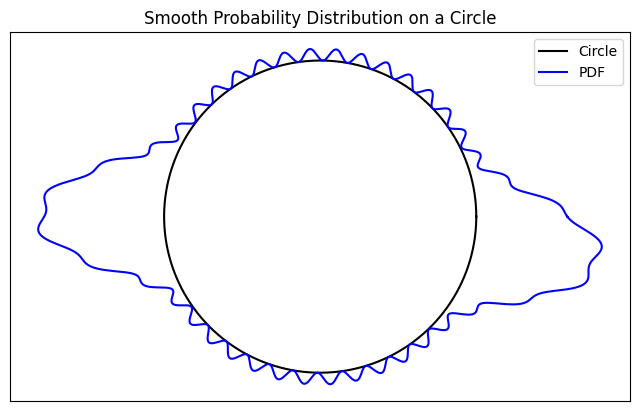

In [103]:
def smooth_circular_distribution2(theta):
    """
    Define a smooth probability density function over the circle.
    Args:
        theta: Angle in radians (array-like).

    Returns:
        PDF values corresponding to each theta.
    """
    # Example: A Gaussian-like bump on the circle centered at theta=pi
    return np.exp(-0.5 * ((theta - np.pi/1.05) % (2 * np.pi) - np.pi)**2 / 0.2**2) + np.exp(-0.5 * ((theta) % (2 * np.pi) - np.pi)**2 / 0.2**2)
                                                                                               
# Generate angles for the circle
angles = np.linspace(0, 2 * np.pi, 1000)
sparse_angles = np.linspace(0,2*np.pi,50)

# Evaluate the PDF
pdf_values = smooth_circular_distribution2(angles) + 0.1 * np.sin(20*angles+np.pi/9)**2

# Normalize the PDF
pdf_values /= np.trapz(pdf_values, angles)  # Ensure integral over the circle is 1

# Convert PDF values to Cartesian coordinates
x_circle = np.cos(angles)
y_circle = np.sin(angles)

x_pdf = (1 + pdf_values) * np.cos(angles)
y_pdf = (1 + pdf_values) * np.sin(angles)

# Plot the circle and the PDF
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black")  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
plt.title("Smooth Probability Distribution on a Circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

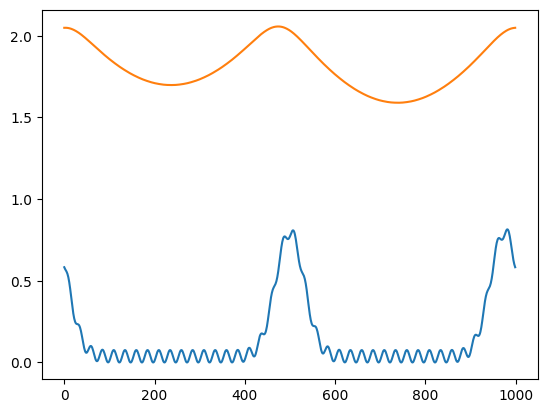

In [104]:
deviation_values = np.array([np.sum([min(np.abs(angles[j]-angles[i]),
                                         2*np.pi-(np.abs(angles[j]-angles[i])))**2*pdf_values[j]*(2*np.pi/1000) 
                                     for j in range(len(angles))])**(1/2) 
                             for i in range(len(angles))])

plt.plot(pdf_values)
plt.plot(deviation_values)
plt.show()

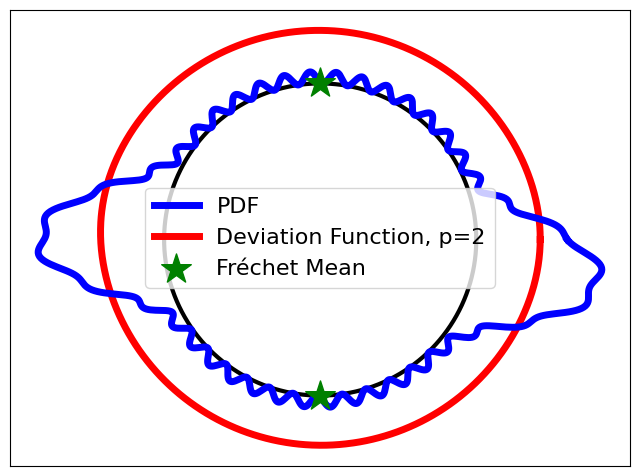

In [105]:
scale_factor = 1/5

# Plot the circle and the PDF
x_min = np.array([0,0])
y_min = np.array([1,-1])

x_deviation = (1 + scale_factor*deviation_values) * np.cos(angles)
y_deviation = (1 + scale_factor*deviation_values) * np.sin(angles)

plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, color="black", linewidth=3)  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue", linewidth=5, zorder = 5) 
plt.plot(x_deviation, y_deviation, label="Deviation Function, p=2", color="red", linewidth=5)  # PDF superimposed
plt.scatter(x_min, y_min, color="green", s=500, marker="*", label="Fréchet Mean", alpha=1,zorder=10)
# plt.title("Smooth Probability Distribution on a Circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=16)

# plt.savefig('distribution.png', format='png', dpi=300)

plt.show()

(1.5, 2.2)

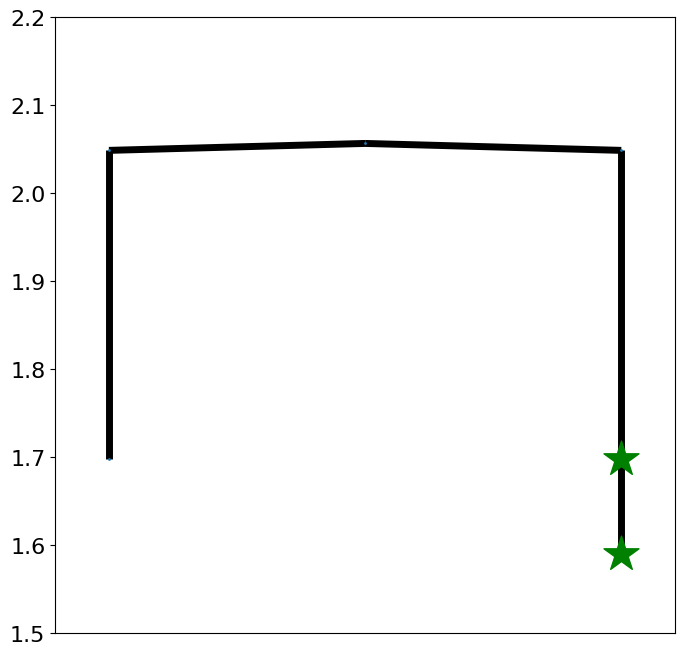

In [106]:
G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])

f = {i:deviation_values[i] for i in range(len(angles))}

T = get_merge_tree(G,f)

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5)

x_min = np.array([pos[0][0],pos[1][0]])
y_min = np.array([pos[0][1],pos[1][1]])

plt.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
ax.set_ylim(1.5, 2.2)

# plt.savefig('distribution_merge_tree.png', format='png', dpi=300)

## Consistency

1.5795581104986467
1.5164201518856506
1.5619356942404734
1.6278983317636881
1.494640717344823


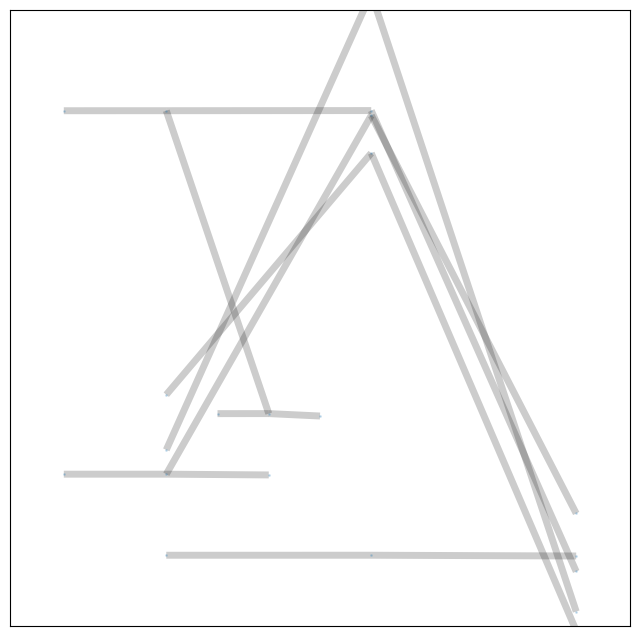

In [111]:
num_runs = 5
num_samples = 100

G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])
scale_factor = 1/5

simplify = True

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for j in range(num_runs):

    sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)
    frechet_mean = circular_frechet_mean(sparse_angles, sampled_angles)

    # Compute deviation values
    deviation_values_sampled = np.array([
        np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
                for j in range(len(sampled_angles))]) ** (1/2) 
        for i in range(len(angles))
    ])
    print(np.min(deviation_values_sampled))
    x_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.cos(angles)
    y_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.sin(angles)

    deviation_values_list.append(deviation_values_sampled)

    # Plot in the corresponding subplot
#     ax = axes[0]

    f = {i:deviation_values_sampled[i] for i in range(len(angles))}
    
    T = get_merge_tree(G,f)
    
    if simplify:
        T = simplify_merge_tree(T)
    
    height = {node:T.nodes[node]['height'] for node in T.nodes()}
    pos = mergeTree_pos(T,height)
    
#     ax = axes[i+4]

    ax.set_ylim(1.5, 2.2)
    
    nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5,alpha = 0.2,ax = ax)
    
    # x_min = np.array([pos[0][0],pos[1][0]])
    # y_min = np.array([pos[0][1],pos[1][1]])

    leaves = [node for node in T.nodes() if T.degree(node)==1]

#     if T.nodes[leaves[0]]['height'] < T.nodes[leaves[1]]['height']:
#         min_node = leaves[0]
#         other_node = leaves[1]
#     else:
#         min_node = leaves[1]
#         other_node = leaves[0]

#     x_min = pos[min_node][0]
#     y_min = pos[min_node][1]

#     x_other = pos[other_node][0]
#     y_other = pos[other_node][1]
    
#     ax.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)
#     ax.scatter(x_other, y_other, color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    if j == 0:
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize=20)
    else:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)



In [ ]:
G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])
scale_factor = 1/5

simplify = True

# Create a 2-row by 3-column grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()  # Flatten to index easily

deviation_values_list = []

n_samples = 500

for i in range(4):
    # Generate samples
    sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values, random_seed = random_seed + i)
    frechet_mean = circular_frechet_mean(sparse_angles, sampled_angles)

    # Compute deviation values
    deviation_values_sampled = np.array([
        np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
                for j in range(len(sampled_angles))]) ** (1/2) 
        for i in range(len(angles))
    ])
    print(np.min(deviation_values_sampled))
    x_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.cos(angles)
    y_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.sin(angles)

    deviation_values_list.append(deviation_values_sampled)

    # Plot in the corresponding subplot
    ax = axes[i]
    ax.plot(x_circle, y_circle, color="black", linewidth=3, alpha=0.7)  # Circle outline
    ax.plot(x_deviation_sampled, y_deviation_sampled, label="Empirical Fréchet Variance", color="red", linewidth=5, zorder=0)
    ax.scatter(x_samples, y_samples, color="blue", s=80, marker="o", label="Sampled Points", alpha=1, zorder=5)
    ax.scatter(np.cos(frechet_mean), np.sin(frechet_mean), color="green", s=800, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", adjustable="box")

    f = {i:deviation_values_sampled[i] for i in range(len(angles))}
    
    T = get_merge_tree(G,f)
    
    if simplify:
        T = simplify_merge_tree(T)
    
    height = {node:T.nodes[node]['height'] for node in T.nodes()}
    pos = mergeTree_pos(T,height)
    
    ax = axes[i+4]

    ax.set_ylim(1.5, 2.2)
    
    nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5,ax = ax)
    
    # x_min = np.array([pos[0][0],pos[1][0]])
    # y_min = np.array([pos[0][1],pos[1][1]])

    leaves = [node for node in T.nodes() if T.degree(node)==1]

    if T.nodes[leaves[0]]['height'] < T.nodes[leaves[1]]['height']:
        min_node = leaves[0]
        other_node = leaves[1]
    else:
        min_node = leaves[1]
        other_node = leaves[0]

    x_min = pos[min_node][0]
    y_min = pos[min_node][1]

    x_other = pos[other_node][0]
    y_other = pos[other_node][1]
    
    ax.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)
    ax.scatter(x_other, y_other, color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    if i == 0:
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize=20)
    else:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


    other_node_circle_value = get_key(f,T.nodes[other_node]['height'])[0]

    ax = axes[i]

    ax.scatter(x_circle[other_node_circle_value], y_circle[other_node_circle_value], color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    

# Adjust layout
plt.tight_layout()

# Save the full figure
# plt.savefig('empirical_grid_trees.png', format='png', dpi=300)

# Show the figure
plt.show()

In [ ]:
# Stability Under Perturbation

Now we perturb the original pdf and compute the resulting merge tree as another manifestation of stability. 

def smooth_circular_distribution2(theta):
    """
    Define a smooth probability density function over the circle.
    Args:
        theta: Angle in radians (array-like).

    Returns:
        PDF values corresponding to each theta.
    """
    # Example: A Gaussian-like bump on the circle centered at theta=pi
    return np.exp(-0.5 * ((theta - np.pi/1.05) % (2 * np.pi) - np.pi)**2 / 0.2**2) + np.exp(-0.5 * ((theta) % (2 * np.pi) - np.pi)**2 / 0.2**2)
                                                                                               
# Generate angles for the circle
angles = np.linspace(0, 2 * np.pi, 1000)
sparse_angles = np.linspace(0,2*np.pi,50)

# Evaluate the PDF
pdf_values = smooth_circular_distribution2(angles) + 0.1 * np.sin(20*angles+np.pi/9)**2

# Normalize the PDF
pdf_values /= np.trapz(pdf_values, angles)  # Ensure integral over the circle is 1

# Convert PDF values to Cartesian coordinates
x_circle = np.cos(angles)
y_circle = np.sin(angles)

x_pdf = (1 + pdf_values) * np.cos(angles)
y_pdf = (1 + pdf_values) * np.sin(angles)

# Plot the circle and the PDF
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black")  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
plt.title("Smooth Probability Distribution on a Circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

deviation_values = np.array([np.sum([min(np.abs(angles[j]-angles[i]),
                                         2*np.pi-(np.abs(angles[j]-angles[i])))**2*pdf_values[j]*(2*np.pi/1000) 
                                     for j in range(len(angles))])**(1/2) 
                             for i in range(len(angles))])

plt.plot(pdf_values)
plt.plot(deviation_values)
plt.show()

scale_factor = 1/5

# Plot the circle and the PDF
x_min = np.array([0,0])
y_min = np.array([1,-1])

x_deviation = (1 + scale_factor*deviation_values) * np.cos(angles)
y_deviation = (1 + scale_factor*deviation_values) * np.sin(angles)

plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, color="black", linewidth=3)  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue", linewidth=5, zorder = 5) 
plt.plot(x_deviation, y_deviation, label="Deviation Function, p=2", color="red", linewidth=5)  # PDF superimposed
plt.scatter(x_min, y_min, color="green", s=500, marker="*", label="Fréchet Mean", alpha=1,zorder=10)
# plt.title("Smooth Probability Distribution on a Circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=16)

# plt.savefig('distribution.png', format='png', dpi=300)

plt.show()

G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])

f = {i:deviation_values[i] for i in range(len(angles))}

T = get_merge_tree(G,f)

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5)

x_min = np.array([pos[0][0],pos[1][0]])
y_min = np.array([pos[0][1],pos[1][1]])

plt.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
ax.set_ylim(1.5, 2.2)

# plt.savefig('distribution_merge_tree.png', format='png', dpi=300)

## Consistency

num_runs = 5
num_samples = 100

G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])
scale_factor = 1/5

simplify = True

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for j in range(num_runs):

    sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)
    frechet_mean = circular_frechet_mean(sparse_angles, sampled_angles)

    # Compute deviation values
    deviation_values_sampled = np.array([
        np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
                for j in range(len(sampled_angles))]) ** (1/2) 
        for i in range(len(angles))
    ])
    print(np.min(deviation_values_sampled))
    x_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.cos(angles)
    y_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.sin(angles)

    deviation_values_list.append(deviation_values_sampled)

    # Plot in the corresponding subplot
#     ax = axes[0]

    f = {i:deviation_values_sampled[i] for i in range(len(angles))}
    
    T = get_merge_tree(G,f)
    
    if simplify:
        T = simplify_merge_tree(T)
    
    height = {node:T.nodes[node]['height'] for node in T.nodes()}
    pos = mergeTree_pos(T,height)
    
#     ax = axes[i+4]

    ax.set_ylim(1.5, 2.2)
    
    nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5,alpha = 0.2,ax = ax)
    
    # x_min = np.array([pos[0][0],pos[1][0]])
    # y_min = np.array([pos[0][1],pos[1][1]])

    leaves = [node for node in T.nodes() if T.degree(node)==1]

#     if T.nodes[leaves[0]]['height'] < T.nodes[leaves[1]]['height']:
#         min_node = leaves[0]
#         other_node = leaves[1]
#     else:
#         min_node = leaves[1]
#         other_node = leaves[0]

#     x_min = pos[min_node][0]
#     y_min = pos[min_node][1]

#     x_other = pos[other_node][0]
#     y_other = pos[other_node][1]
    
#     ax.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)
#     ax.scatter(x_other, y_other, color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    if j == 0:
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize=20)
    else:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)



G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])
scale_factor = 1/5

simplify = True

# Create a 2-row by 3-column grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()  # Flatten to index easily

deviation_values_list = []

n_samples = 500

for i in range(4):
    # Generate samples
    sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values, random_seed = random_seed + i)
    frechet_mean = circular_frechet_mean(sparse_angles, sampled_angles)

    # Compute deviation values
    deviation_values_sampled = np.array([
        np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
                for j in range(len(sampled_angles))]) ** (1/2) 
        for i in range(len(angles))
    ])
    print(np.min(deviation_values_sampled))
    x_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.cos(angles)
    y_deviation_sampled = (1 + scale_factor * deviation_values_sampled) * np.sin(angles)

    deviation_values_list.append(deviation_values_sampled)

    # Plot in the corresponding subplot
    ax = axes[i]
    ax.plot(x_circle, y_circle, color="black", linewidth=3, alpha=0.7)  # Circle outline
    ax.plot(x_deviation_sampled, y_deviation_sampled, label="Empirical Fréchet Variance", color="red", linewidth=5, zorder=0)
    ax.scatter(x_samples, y_samples, color="blue", s=80, marker="o", label="Sampled Points", alpha=1, zorder=5)
    ax.scatter(np.cos(frechet_mean), np.sin(frechet_mean), color="green", s=800, marker="*", label="Empirical Fréchet Mean", alpha=1, zorder=10)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", adjustable="box")

    f = {i:deviation_values_sampled[i] for i in range(len(angles))}
    
    T = get_merge_tree(G,f)
    
    if simplify:
        T = simplify_merge_tree(T)
    
    height = {node:T.nodes[node]['height'] for node in T.nodes()}
    pos = mergeTree_pos(T,height)
    
    ax = axes[i+4]

    ax.set_ylim(1.5, 2.2)
    
    nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 1,width = 5,ax = ax)
    
    # x_min = np.array([pos[0][0],pos[1][0]])
    # y_min = np.array([pos[0][1],pos[1][1]])

    leaves = [node for node in T.nodes() if T.degree(node)==1]

    if T.nodes[leaves[0]]['height'] < T.nodes[leaves[1]]['height']:
        min_node = leaves[0]
        other_node = leaves[1]
    else:
        min_node = leaves[1]
        other_node = leaves[0]

    x_min = pos[min_node][0]
    y_min = pos[min_node][1]

    x_other = pos[other_node][0]
    y_other = pos[other_node][1]
    
    ax.scatter(x_min, y_min, color="green", s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)
    ax.scatter(x_other, y_other, color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    if i == 0:
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize=20)
    else:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


    other_node_circle_value = get_key(f,T.nodes[other_node]['height'])[0]

    ax = axes[i]

    ax.scatter(x_circle[other_node_circle_value], y_circle[other_node_circle_value], color="lightgreen", s=800, marker="*", label="Fréchet Means", alpha=1,zorder=10)

    

# Adjust layout
plt.tight_layout()

# Save the full figure
# plt.savefig('empirical_grid_trees.png', format='png', dpi=300)

# Show the figure
plt.show()